In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
prev_days = 84 # Number of previous days to feed in model
forecast_days = 28 # Number of days for which u want to carry out forecast

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from keras import metrics
from keras.models import load_model
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [42]:
path = "/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Purely_Time_Series_Demo_Project/amartya/spain_energy_market.csv"
print("\nOriginal Data:")
data = pd.read_csv(path, sep=",", parse_dates=["datetime"])
print(data.info())
print(data.head())
print(data.name.unique())


print("\nJust Picking up rows with 'Total demand PBF' & ignoring all other rows:")
data = data[data["name"]=="Demanda programada PBF total"]
print(data.info())
print(data.head())
print(data.tail())
print(data.id.unique())
print(data.geoid.unique())
print(data.geoname.unique())


print("\nDataframe after droping Unecessary Column:")
data = data.drop(columns = ["id", "geoid", "geoname", "name"])
print(data.info())
print(data.head())
print(data.tail())


Original Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  40212 non-null  datetime64[ns]
 1   id        40212 non-null  int64         
 2   name      34734 non-null  object        
 3   geoid     10956 non-null  float64       
 4   geoname   10956 non-null  object        
 5   value     40212 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.8+ MB
None
             datetime   id  ... geoname      value
0 2014-01-01 23:00:00  600  ...  España  25.280833
1 2014-01-02 23:00:00  600  ...  España  39.924167
2 2014-01-03 23:00:00  600  ...  España   4.992083
3 2014-01-04 23:00:00  600  ...  España   4.091667
4 2014-01-05 23:00:00  600  ...  España  13.587500

[5 rows x 6 columns]
['Precio mercado SPOT Diario ESP' 'Precio mercado SPOT Diario FRA'
 'Precio mercado SPOT Diari

In [43]:
training_set = data.iloc[0:-(forecast_days*2)-prev_days,:]
testing_set = data.iloc[-(forecast_days*2)-prev_days:,:]


print("Training Set Information:")
print(training_set.info())
print(training_set.head())
print(training_set.tail())

print("\nTraining Set values array:")
training_set_values = training_set.iloc[:, 1:2].values
print(training_set_values)


print("\n\nTesting Set Information:")
print(testing_set.info())
print(testing_set.head())
print(testing_set.tail())

print("\nTesting Set values array:")
testing_set_values = testing_set.iloc[:, 1:2].values
print(testing_set_values)

Training Set Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 21994 to 23678
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  1685 non-null   datetime64[ns]
 1   value     1685 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB
None
                 datetime     value
21994 2014-01-01 23:00:00  620107.7
21995 2014-01-02 23:00:00  659865.2
21996 2014-01-03 23:00:00  632536.8
21997 2014-01-04 23:00:00  610251.7
21998 2014-01-05 23:00:00  572534.1
                 datetime     value
23674 2018-08-08 22:00:00  697596.5
23675 2018-08-09 22:00:00  680054.9
23676 2018-08-10 22:00:00  625144.9
23677 2018-08-11 22:00:00  582802.2
23678 2018-08-12 22:00:00  658113.1

Training Set values array:
[[620107.7]
 [659865.2]
 [632536.8]
 ...
 [625144.9]
 [582802.2]
 [658113.1]]


Testing Set Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index:

In [44]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_values_scaled = scaler.fit_transform(training_set_values)
testing_set_values_scaled = scaler.fit_transform(testing_set_values)

In [45]:
X_train = []
Y_train = []

for i in range(prev_days, len(training_set_values_scaled)-forecast_days):
    X_train.append(training_set_values_scaled[i-prev_days:i, 0])
    Y_train.append(training_set_values_scaled[i:i+forecast_days, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)

(1573, 84)
(1573, 28)


In [46]:
X_test = []
Y_test = []
for i in range(prev_days, len(testing_set_values_scaled)-forecast_days):
    X_test.append(testing_set_values_scaled[i-prev_days:i, 0])
    Y_test.append(testing_set_values_scaled[i:i+forecast_days, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)

(28, 84)
(28, 28)


In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
print(X_train.shape)
print(Y_train.shape)
print(X_train[0:3,:,:])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
print(X_test.shape)
print(Y_test.shape)
print(X_train[0:3,:,:])

(1573, 84, 1)
(1573, 28, 1)
[[[0.38015529]
  [0.49952202]
  [0.41747205]
  [0.35056394]
  [0.23732174]
  [0.60692851]
  [0.63938503]
  [0.5924805 ]
  [0.55747557]
  [0.38951098]
  [0.3370902 ]
  [0.58015728]
  [0.68238918]
  [0.68150468]
  [0.68211326]
  [0.65426448]
  [0.45866307]
  [0.37087197]
  [0.63551197]
  [0.68984496]
  [0.68412425]
  [0.6672116 ]
  [0.60758333]
  [0.46734202]
  [0.3731994 ]
  [0.63586025]
  [0.71366126]
  [0.67283924]
  [0.71901689]
  [0.69019954]
  [0.49702375]
  [0.36674581]
  [0.66393301]
  [0.73406687]
  [0.75783003]
  [0.72490484]
  [0.69365527]
  [0.55508208]
  [0.42900295]
  [0.72520237]
  [0.72131821]
  [0.69353097]
  [0.70451334]
  [0.6757023 ]
  [0.47076923]
  [0.33844217]
  [0.6060272 ]
  [0.63389099]
  [0.6474479 ]
  [0.67501986]
  [0.6321295 ]
  [0.34700042]
  [0.36259323]
  [0.58234751]
  [0.66726954]
  [0.61617701]
  [0.56782654]
  [0.58542614]
  [0.39131931]
  [0.31626246]
  [0.64451158]
  [0.68242551]
  [0.61589178]
  [0.5651151 ]
  [0.5047134

In [50]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = forecast_days))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = forecast_days))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [51]:
model_training_record_stats = regressor.fit(X_train, Y_train, epochs = 50, batch_size = 16, validation_split=0.1, validation_batch_size=16)

Epoch 1/50
89/89 [==============================] - 24s 184ms/step - loss: 0.1076 - val_loss: 0.0283
Epoch 2/50
89/89 [==============================] - 15s 163ms/step - loss: 0.0511 - val_loss: 0.0259
Epoch 3/50
89/89 [==============================] - 14s 158ms/step - loss: 0.0463 - val_loss: 0.0253
Epoch 4/50
89/89 [==============================] - 14s 156ms/step - loss: 0.0429 - val_loss: 0.0260
Epoch 5/50
89/89 [==============================] - 14s 156ms/step - loss: 0.0412 - val_loss: 0.0259
Epoch 6/50
89/89 [==============================] - 14s 155ms/step - loss: 0.0401 - val_loss: 0.0259
Epoch 7/50
89/89 [==============================] - 14s 155ms/step - loss: 0.0391 - val_loss: 0.0248
Epoch 8/50
89/89 [==============================] - 14s 155ms/step - loss: 0.0379 - val_loss: 0.0242
Epoch 9/50
89/89 [==============================] - 14s 154ms/step - loss: 0.0375 - val_loss: 0.0239
Epoch 10/50
89/89 [==============================] - 14s 152ms/step - loss: 0.0368 - val_lo

dict_keys(['loss', 'val_loss'])


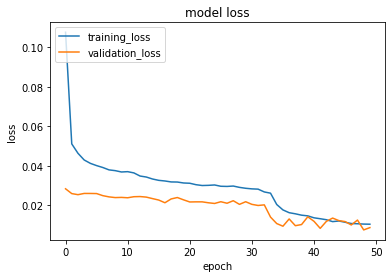

In [52]:
print(model_training_record_stats.history.keys())

plt.plot(model_training_record_stats.history['loss'])
plt.plot(model_training_record_stats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper left')
plt.show()

In [53]:
regressor.save("/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Purely_Time_Series_Demo_Project/amartya/model_1.h5")
print("Saved model to disk")

Saved model to disk


In [54]:
regressor = load_model("/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Purely_Time_Series_Demo_Project/amartya/model_1.h5")
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 84, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 84, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 84, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 84, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 84, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 84, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 28)               

In [55]:
keras_evaluation = regressor.evaluate(X_test, Y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.0608


In [56]:
predicted_values = regressor.predict(X_test)

In [57]:
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
predicted_values = predicted_values.reshape(predicted_values.shape[0], predicted_values.shape[1])

predicted_values = scaler.inverse_transform(predicted_values)
Y_test = scaler.inverse_transform(Y_test)

In [61]:
print(Y_test.shape)
print(predicted_values.shape)

mean_squared_error_array=[]
for i in range(forecast_days):
    mean_squared_error_array.append(mean_squared_error(Y_test[i],predicted_values[i]))

root_mean_squared_error_array = np.sqrt(np.array(mean_squared_error_array))

print("Median Root Mean Squared Error: ",np.median(root_mean_squared_error_array), "MWh i.e. MegaWattHour")
print("Accuracy Based on Median RMSE ",100-((np.median(root_mean_squared_error_array)/np.max(Y_test))*100),"%")

print("Max Root Mean Squared Error: ",np.max(root_mean_squared_error_array), "MWh i.e. MegaWattHour")
print("Accuracy Based on Max RMSE ",100-((np.max(root_mean_squared_error_array)/np.max(Y_test))*100),"%")

(28, 28)
(28, 28)
Median Root Mean Squared Error:  53031.03577258471 MWh i.e. MegaWattHour
Accuracy Based on Median RMSE  92.84579725811939 %
Max Root Mean Squared Error:  60325.239791313514 MWh i.e. MegaWattHour
Accuracy Based on Max RMSE  91.86176566925113 %


In [59]:
print(Y_test)

[[702392.7 704401.6 687658.  660520.3 614431.4 569407.6 669656.8 681256.5
  692971.2 686835.3 671507.9 611657.2 568718.6 674977.6 703811.6 719100.9
  712368.1 710996.3 625322.3 588791.2 697420.3 721354.5 734391.2 711439.6
  702207.  642247.2 597570.6 685913.4]
 [704401.6 687658.  660520.3 614431.4 569407.6 669656.8 681256.5 692971.2
  686835.3 671507.9 611657.2 568718.6 674977.6 703811.6 719100.9 712368.1
  710996.3 625322.3 588791.2 697420.3 721354.5 734391.2 711439.6 702207.
  642247.2 597570.6 685913.4 697872. ]
 [687658.  660520.3 614431.4 569407.6 669656.8 681256.5 692971.2 686835.3
  671507.9 611657.2 568718.6 674977.6 703811.6 719100.9 712368.1 710996.3
  625322.3 588791.2 697420.3 721354.5 734391.2 711439.6 702207.  642247.2
  597570.6 685913.4 697872.  688046.4]
 [660520.3 614431.4 569407.6 669656.8 681256.5 692971.2 686835.3 671507.9
  611657.2 568718.6 674977.6 703811.6 719100.9 712368.1 710996.3 625322.3
  588791.2 697420.3 721354.5 734391.2 711439.6 702207.  642247.2 59757

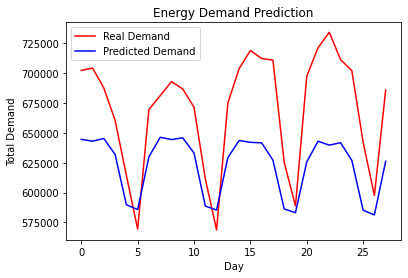

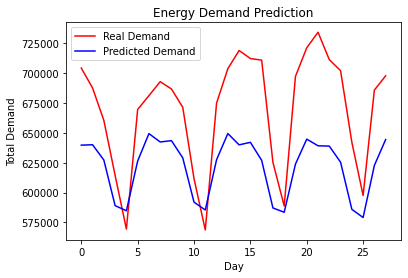

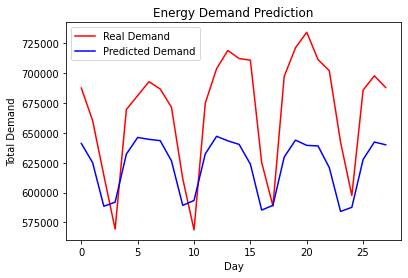

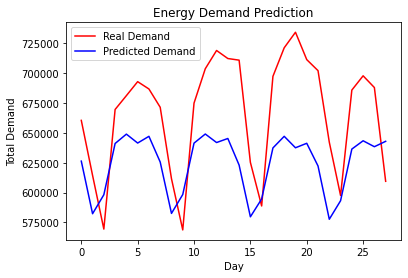

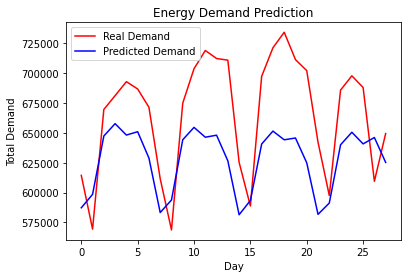

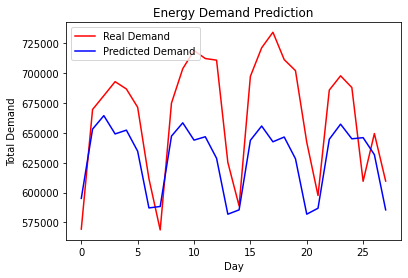

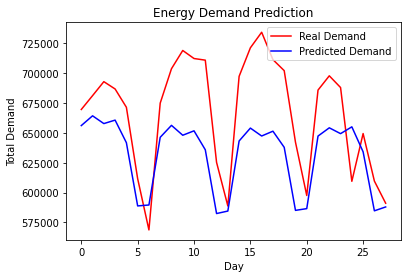

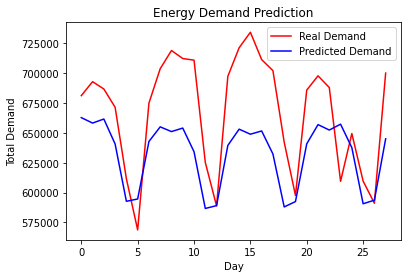

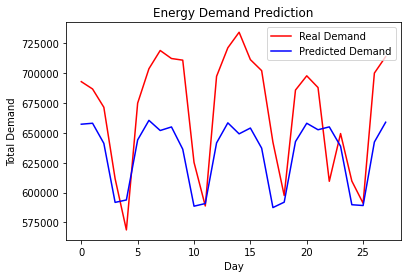

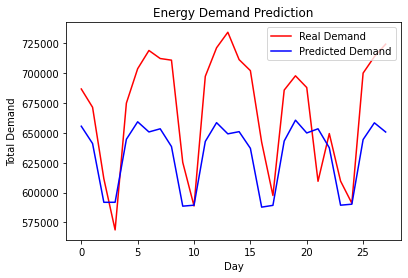

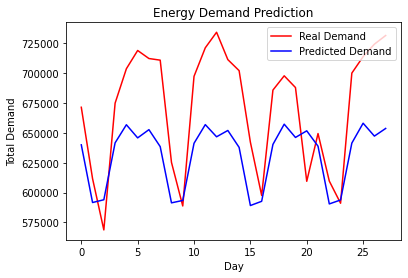

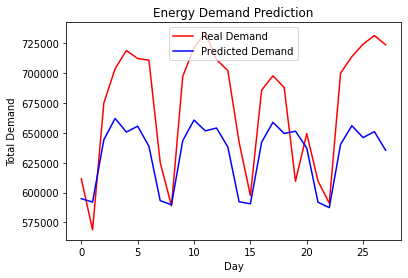

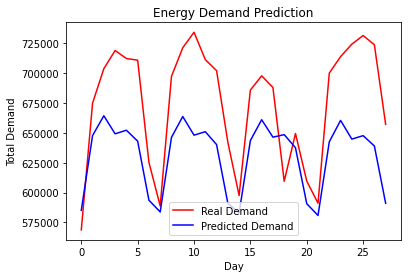

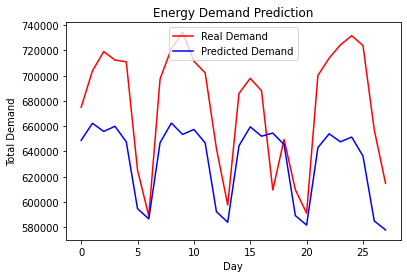

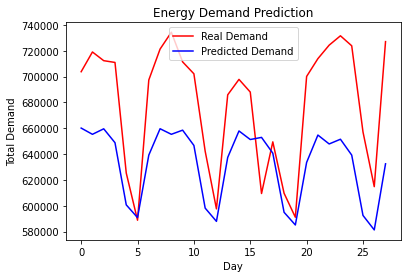

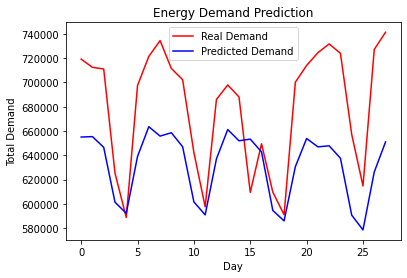

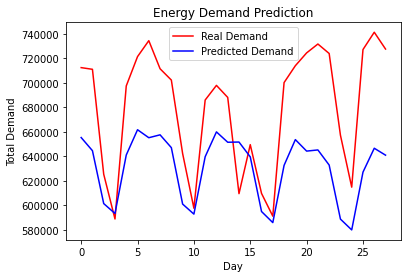

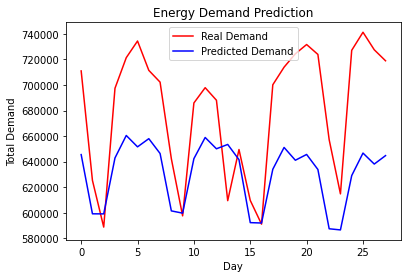

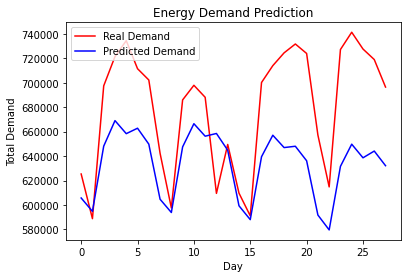

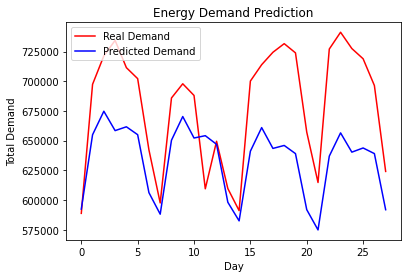

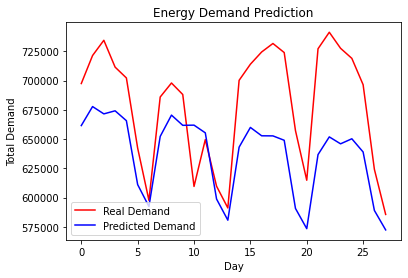

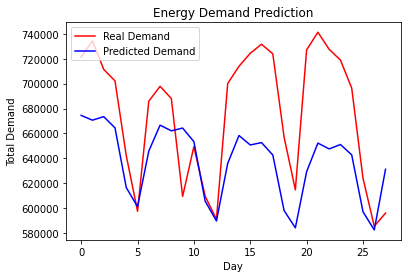

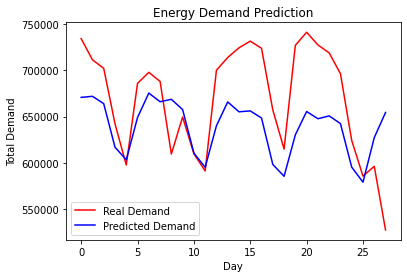

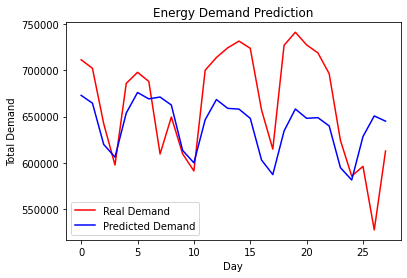

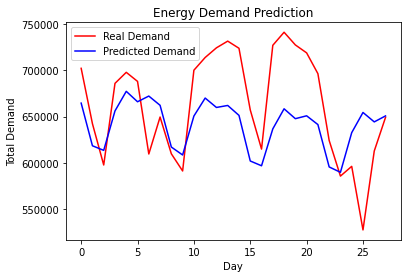

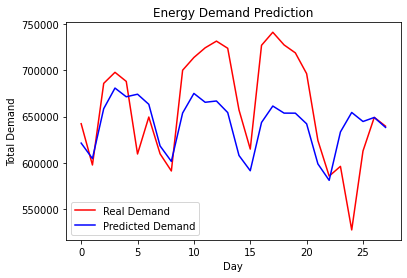

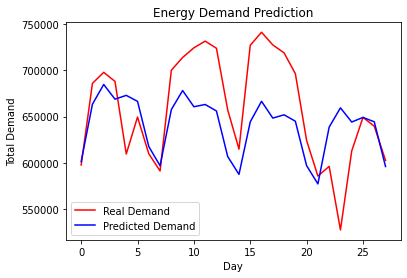

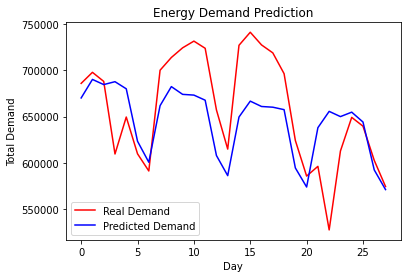

In [60]:
for i in range(forecast_days):
    plt.plot(Y_test[i], color = 'red', label = 'Real Demand')
    plt.plot(predicted_values[i], color = 'blue', label = 'Predicted Demand')
    plt.title('Energy Demand Prediction')
    plt.xlabel('Day')
    plt.ylabel('Total Demand')
    plt.legend()
    plt.show()